In [1]:
import pathlib

# Define data directory
train_dir = pathlib.Path('data/original/train')
test_dir = pathlib.Path('data/original/test')
train_masks_dir = pathlib.Path('external_contours_masks/train')
test_masks_dir = pathlib.Path('external_contours_masks/test')

In [2]:
# Convert all the images in train masks and test masks to png
import os
from PIL import Image

for img_path in train_masks_dir.glob('*.jpg'):
    os.remove(img_path)

for img_path in test_masks_dir.glob('*.jpg'):
    os.remove(img_path)

In [3]:
import os
import cv2
import numpy as np

# check if the pixels are normalized
img = cv2.imread(os.path.join(test_dir, 'P1MF1_C.Png'), cv2.IMREAD_GRAYSCALE)
print(np.max(img), np.min(img))
img_mask = cv2.imread(os.path.join(test_masks_dir, 'P1MF1_C.Png'), cv2.IMREAD_GRAYSCALE)
print(np.max(img_mask), np.min(img_mask))
print(img.shape, img_mask.shape)

255 0
233 0
(4096, 4096) (4096, 4096)


In [4]:
X_train = []
y_train = []
X_test = []
y_test = []

for img_path in train_dir.glob('*.png'):
    img = cv2.imread(str(img_path))
    img = cv2.resize(img, (256, 256))
    X_train.append(img)
    mask_path = os.path.join(train_masks_dir, img_path.stem + '.Png')
    img_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    img_mask = cv2.resize(img_mask, (256, 256))
    y_train.append(img_mask)

for img_path in test_dir.glob('*.png'):
    img = cv2.imread(str(img_path))
    img = cv2.resize(img, (256, 256))
    X_test.append(img)
    mask_path = os.path.join(test_masks_dir, img_path.stem + '.Png')
    img_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    img_mask = cv2.resize(img_mask, (256, 256))
    y_test.append(img_mask)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# # Expand the dimensions of the images
#X_train = np.expand_dims(X_train, axis = 3)
y_train = np.expand_dims(y_train, axis = 3)
#X_test = np.expand_dims(X_test, axis = 3)
y_test = np.expand_dims(y_test, axis = 3)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(50, 256, 256, 3) (50, 256, 256, 1)
(13, 256, 256, 3) (13, 256, 256, 1)


In [5]:
from random import random
import tensorflow as tf
# random seed
SEED = 42

def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(SEED)
   tf.random.set_seed(SEED)
   tf.keras.utils.set_random_seed(SEED)
   np.random.seed(SEED)
   tf.config.experimental.enable_op_determinism()

# reset_random_seeds()
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [6]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.round(tf.cast(input_mask, tf.float32) / 255.0)
    return input_image, input_mask

def load_image(input_image, input_mask):
    input_image = tf.image.resize(input_image, (128, 128))
    input_mask = tf.image.resize(input_mask,(128, 128), method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [7]:
TRAIN_LENGTH = len(X_train)
BATCH_SIZE = 4
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [8]:
train_ds = train_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

print("the shape of the train dataset is: ", train_ds)
# Show the labels of the first image
for image, mask in train_ds.take(1):
    print(" median value of the image is: ", np.median(mask.numpy()))
    # print("the shape of the image is: ", image.numpy().shape)
    # print("the shape of the mask is: ", mask.numpy().shape)
    # print("the label of the first image is: ", mask.numpy())

the shape of the train dataset is:  <_ParallelMapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None))>
 median value of the image is:  1.0


In [9]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    # do augmentation in ratio of 1 to 5 images in the train
    self.augment_inputs = tf.keras.Sequential([
        tf.keras.layers.RandomFlip(mode="horizontal", seed=seed),
        tf.keras.layers.RandomRotation(factor=0.2, seed=seed),
        tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2, seed=seed),
        tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, seed=seed),
        tf.keras.layers.RandomContrast(factor=0.2, seed=seed),
    ], name="augment_inputs")

    self.augment_labels = tf.keras.Sequential([
        tf.keras.layers.RandomFlip(mode="horizontal", seed=seed),
        tf.keras.layers.RandomRotation(factor=0.2, seed=seed),
        tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2, seed=seed),
        tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, seed=seed),
    ], name="augment_labels")

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


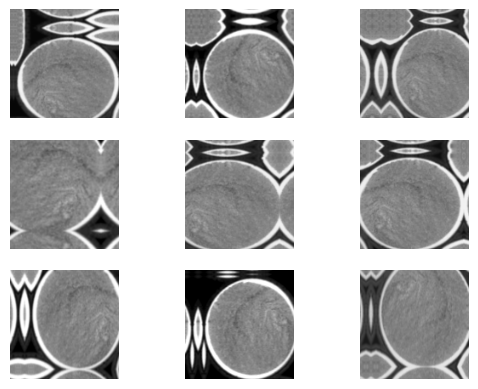

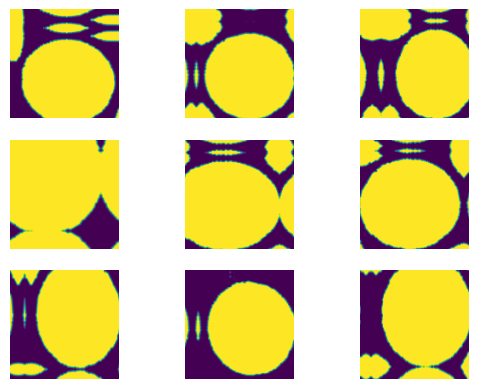

In [10]:
from matplotlib import pyplot as plt
# plot 9 augmentations of the image and the mask for one original image and its mask
for image, mask in train_ds.take(1):
    # random seed array
    seed = [int(random() * 100) for i in range(9)]
    for i in range(9):
        plt.subplot(330 + 1 + i)
        augmented_image, augmented_mask = Augment(seed[i])(image, mask)
        plt.imshow(augmented_image.numpy())
        plt.axis("off")
    plt.show()
    for i in range(9):
        plt.subplot(330 + 1 + i)
        augmented_image, augmented_mask = Augment(seed[i])(image, mask)
        plt.imshow(augmented_mask.numpy())
        plt.axis("off")
    plt.show()

In [11]:
train_batches = (
    train_ds
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches, val_batches = test_ds.take(len(X_test) // 2).batch(BATCH_SIZE), test_ds.skip(len(X_test) // 2).batch(BATCH_SIZE)

In [12]:
from matplotlib import pyplot as plt

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    # print the unique values of the image
    #print(np.unique(display_list[i]))
    plt.axis('off')
  plt.show()

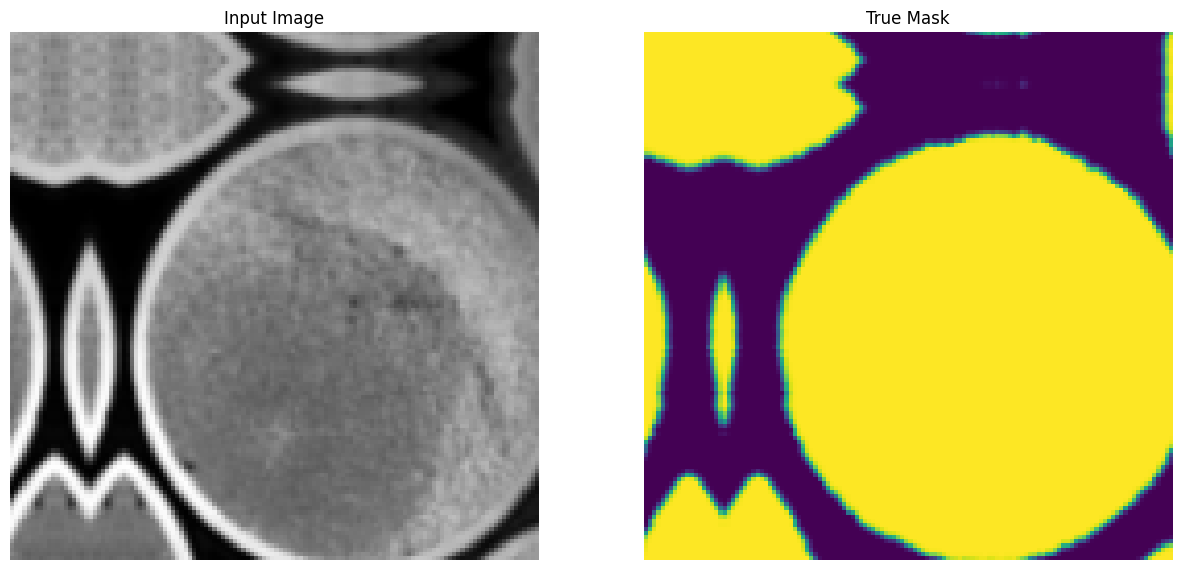

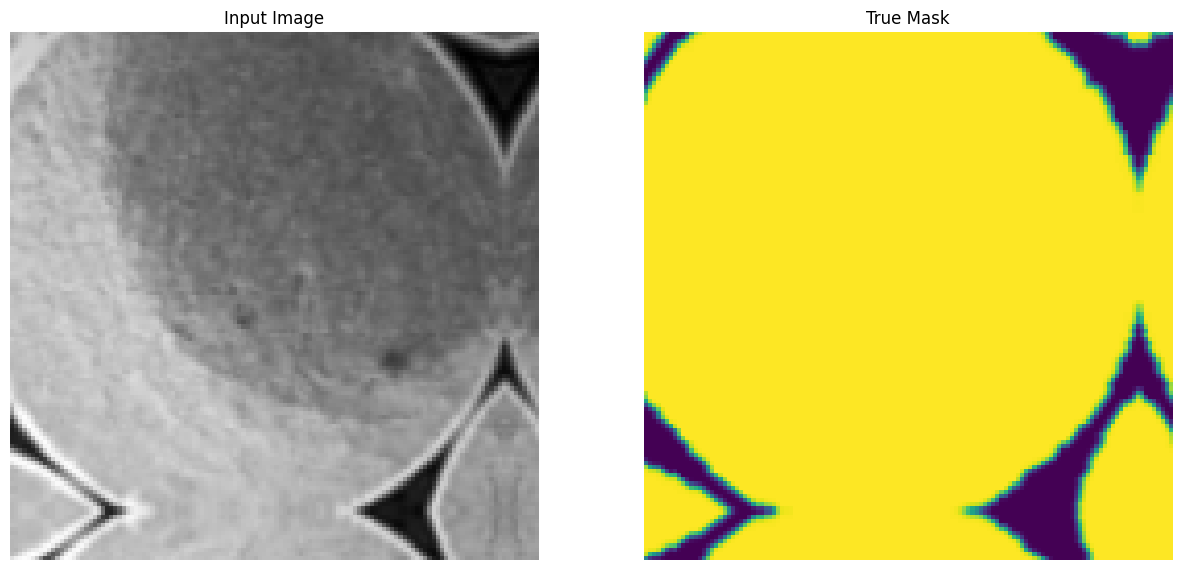

In [13]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

# Make the last two layers trainable, but keep the rest frozen
for layer in down_stack.layers:  # Exclude the last two layers
    layer.trainable = False

# # Now, set the last two layers to be trainable
# for layer in down_stack.layers[-1:]:
#     layer.trainable = True

In [15]:
from tensorflow_examples.models.pix2pix import pix2pix

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    pix2pix.upsample(32, 3),   # 64x64 -> 128x128
]

# Make the last two layers of the up_stack trainable, but keep the rest frozen
for layer in up_stack:  # Exclude the last two layers
    layer.trainable = False

# # Now, set the last two layers to be trainable
for layer in up_stack[-1:]:
    layer.trainable = True


In [16]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [17]:
# Try the model
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [18]:
class WeightedSCCE(tf.keras.losses.Loss):
    def __init__(self, class_weight, from_logits=False, name='weighted_scce'):
        if class_weight is None or all(v == 1. for v in class_weight):
            self.class_weight = None
        else:
            self.class_weight = tf.convert_to_tensor(class_weight,
                dtype=tf.float32)
        self.name = name
        self.reduction = tf.keras.losses.Reduction.NONE
        self.unreduced_scce = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=from_logits, name=name,
            reduction=self.reduction)

    def __call__(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, dtype=tf.int32)
        loss = self.unreduced_scce(y_true, y_pred, sample_weight)
        if self.class_weight is not None:
            weight_mask = tf.gather(self.class_weight, y_true)
            loss = tf.math.multiply(loss, weight_mask)
        return loss


In [35]:
import tensorflow as tf
from tensorflow import keras


os.environ["SM_FRAMEWORK"] = "tf.keras"

# AttributeError: module 'keras.utils' has no attribute 'generic_utils;, how to solve this?

# Set the image data format to channels_last
keras.backend.set_image_data_format('channels_last')
import segmentation_models as sm


# Assuming OUTPUT_CLASSES is the number of classes in your segmentation task
OUTPUT_CLASSES = 2

# Create the U-Net model
# model = unet_model(output_channels=OUTPUT_CLASSES)
# Unet for segmentation
model = sm.Unet('resnet34', classes=OUTPUT_CLASSES, activation='softmax', encoder_weights='imagenet', input_shape=(128, 128, 3))

# Compile the model
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [21]:
show_predictions(train_batches, 3)

ValueError: Input 0 of layer "functional_41" is incompatible with the layer: expected shape=(None, 3, 128, 128), found shape=(4, 128, 128, 3)

In [ ]:
from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    #clear_output(wait=True)
    show_predictions(train_batches, 1)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
from keras.callbacks import EarlyStopping

EPOCHS = 200
VAL_SUBSPLITS = 5
VALIDATION_STEPS = len(X_test) // 2 // BATCH_SIZE
STEPS_PER_EPOCH = len(X_train) // BATCH_SIZE

early_stopping = EarlyStopping(
    monitor='val_loss',  # The metric to monitor (e.g., validation loss)
    patience=20,         # Number of epochs to wait without improvement
    restore_best_weights=True  # Restore the model to the best weights
)

# model_history = model.fit(train_batches, epochs=EPOCHS,
#                           steps_per_epoch=STEPS_PER_EPOCH,
#                           validation_steps=VALIDATION_STEPS,
#                           validation_data=val_batches,
#                           callbacks=[DisplayCallback(), early_stopping])

In [ ]:
# evaluate the model and print result and iou
loss, acc = model.evaluate(test_batches, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))
iou = tf.keras.metrics.MeanIoU(num_classes=2)
for images, labels in test_batches:
    pred = model.predict(images)
    pred = tf.argmax(pred, axis=-1)
    pred = pred[..., tf.newaxis]
    iou.update_state(labels, pred)
print("Mean IoU =", iou.result().numpy())

In [ ]:
# import matplotlib.pyplot as plt
# 
# # Extract data from the model history
# train_loss = model_history.history['loss']
# val_loss = model_history.history['val_loss']
# 
# # Create an array of the epoch numbers for the x-axis
# epochs = range(1, len(train_loss) + 1)
# 
# # Plot the training loss
# plt.figure(figsize=(10, 6))
# plt.plot(epochs, train_loss, 'b', label='Training Loss')
# plt.plot(epochs, val_loss, 'r', label='Validation Loss')
# plt.axvline(x=early_stopping.best_epoch, color='g', label='Best Epoch')
# plt.title('Training and Validation Loss - External Contours')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid()
# plt.show()

In [ ]:
# # Plot the training and testing accuracy
# train_acc = model_history.history['accuracy']
# val_acc = model_history.history['val_accuracy']
# 
# plt.figure(figsize=(10, 6))
# plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
# plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
# plt.axvline(x=early_stopping.best_epoch, color='g', label='Best Epoch')
# plt.title('Training and Validation Accuracy - External Contours')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid()
# plt.show()

In [ ]:
# # Save the model
# tf.keras.models.save_model(model, 'unet_model')

In [ ]:
# print the number of the epoch as selected
# by the early stopping callback
# print(early_stopping.best_epoch)

In [33]:
import numpy as np
import tensorflow as tf
from sklearn.linear_model import Ridge
from tensorflow.keras.layers import Layer, Input, Flatten, Reshape, Lambda
from tensorflow.keras import Model
import segmentation_models as sm

# Step 1: Extract features using the feature extractor
last_layer_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
last_layer_model.trainable = False

X_train_last_layer = []
y_train_list = []

for image, mask in train_ds.take(10):  # Use a subset of the training data
    image_batch = tf.expand_dims(image, 0)  # Add batch dimension
    last_layer = last_layer_model(image_batch, training=False)  # Get features, ensure training=False
    last_layer = tf.reshape(last_layer, (1, -1)).numpy()  # Flatten and convert to numpy
    X_train_last_layer.append(last_layer[0])  # Append flattened features
    y_train_list.append(mask.numpy().flatten())  # Flatten mask and append

X_train_last_layer = np.array(X_train_last_layer)
y_train = np.array(y_train_list)

print("X_train_last_layer shape:", X_train_last_layer.shape)
print("y_train shape:", y_train.shape)

# Step 2: Train the Ridge regression model
clf = Ridge(alpha=1.0)
clf.fit(X_train_last_layer, y_train)

print("clf.coef_.shape:", clf.coef_.shape)
print("clf.intercept_.shape:", clf.intercept_.shape)

# Step 3: Create a custom layer to apply the Ridge regression coefficients
class RidgeLayer(Layer):
    def __init__(self, coefficients, intercept, **kwargs):
        super(RidgeLayer, self).__init__(**kwargs)
        self.coefficients = coefficients
        self.intercept = intercept

    def build(self, input_shape):
        self.kernel = self.add_weight(
            name="kernel",
            shape=(input_shape[-1], self.coefficients.shape[0]),
            initializer=tf.keras.initializers.Constant(self.coefficients.T),
            trainable=False
        )
        self.bias = self.add_weight(
            name="bias",
            shape=(self.intercept.shape[0],),
            initializer=tf.keras.initializers.Constant(self.intercept),
            trainable=False
        )
        
    def get_config(self):
        config = super(RidgeLayer, self).get_config()
        config.update({
            'coefficients': self.coefficients.tolist(),  # Convert numpy array to list
            'intercept': self.intercept.tolist()        # Convert numpy array to list
        })
        return config

    def call(self, inputs):
        return tf.matmul(inputs, self.kernel) + self.bias

# Step 4: Create the unified model
inputs = Input(shape=(128, 128, 3))  # NHWC format, which is the default for TensorFlow
x = last_layer_model(inputs, training=False)  # Ensure training=False
x = Flatten()(x)
x = RidgeLayer(coefficients=clf.coef_, intercept=clf.intercept_)(x)
x = Reshape((128, 128, 1))(x)

# Use a Lambda layer for operations that might cause issues outside of a layer
x = Lambda(lambda z: tf.cast(tf.greater(z, 0.5), tf.int32))(x)

channel_0 = Lambda(lambda z: 1 - z)(x)
channel_1 = x  # This is already the predicted class

outputs = Lambda(lambda z: tf.stack(z, axis=-1))([channel_0, channel_1])
print("The shape of the output is:", outputs.shape)

unified_model = Model(inputs=inputs, outputs=outputs)

unified_model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])

# Evaluate the model using test_batches
iou = tf.keras.metrics.MeanIoU(num_classes=2)
for images, labels in test_batches:
    pred = unified_model.predict(images)
    print("The shape of the prediction is:", pred.shape)
    pred = tf.argmax(pred, axis=-1)
    pred = pred[..., tf.newaxis]
    iou.update_state(labels, pred)
    
print("Mean IoU =", iou.result().numpy())

# Save the model
tf.saved_model.save(unified_model, 'unified_model')


UnimplementedError: Exception encountered when calling layer 'conv0' (type Conv2D).

{{function_node __wrapped__Conv2D_device_/job:localhost/replica:0/task:0/device:CPU:0}} The Conv2D op currently only supports the NHWC tensor format on the CPU. The op was given the format: NCHW [Op:Conv2D] name: 

Call arguments received by layer 'conv0' (type Conv2D):
  • inputs=tf.Tensor(shape=(1, 3, 134, 134), dtype=float32)